In [1]:
mseed = 2
import numpy as np
np.random.seed(mseed)
import torch
torch.manual_seed(mseed)

import time
import h5py
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl

from torch import nn
import torch.nn.functional as F
import torcheval.metrics
from torch.utils.data import Dataset, DataLoader, random_split

import copy

import sys

masterdir = '/home/seismoai/data/forecasting/'
blockdir = masterdir + 'blockdata/'
modeldir = masterdir + 'models/'

/home/jkoehler/ENVS/forecasting_venv/lib/python3.8/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
if torch.cuda.is_available():
    print('Cuda Available')
else:
    print('No GPU support currently')

device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda Available


# 1. Create Architecture

In [3]:
def make_model():
    class Autoencoder(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv0 = nn.Conv2d(in_channels= 1, out_channels=  4, kernel_size=4)
            self.conv1 = nn.Conv2d(in_channels= 4, out_channels=  8, kernel_size=4)
            self.conv2 = nn.Conv2d(in_channels= 8, out_channels= 16, kernel_size=4)
            self.conv3 = nn.Conv2d(in_channels=16, out_channels= 32, kernel_size=4)
            
            self.tconv3 = nn.ConvTranspose2d(in_channels=32,   out_channels= 16,  kernel_size=4)
            self.tconv2 = nn.ConvTranspose2d(in_channels=16,   out_channels=  8,  kernel_size=4)
            self.tconv1 = nn.ConvTranspose2d(in_channels= 8,   out_channels=  4,  kernel_size=4)
            self.tconv0 = nn.ConvTranspose2d(in_channels= 4,   out_channels=  1,  kernel_size=4)
            
            self.acti = nn.functional.relu
            self.facti = nn.functional.sigmoid 
            #self.facti = nn.functional.leaky_relu

        def forward(self, x):
            y = self.acti(self.conv0(x.view(-1, 1, 32, 32)))
            x = self.acti(self.conv1(y))
            z = self.acti(self.conv2(x))
            x = self.acti(self.conv3(z))
            
            x = self.acti(self.tconv3(x))
            x = self.acti(self.tconv2(x+z))
            x = self.acti(self.tconv1(x))
            x = self.acti(self.tconv0(x+y))
            
            return self.acti(x).view(-1, 32, 32)
    
    return Autoencoder().to(device)

# 2 Load the right Data
1999 - 2010 (incl) no_EQ class

In [4]:
class BlockDataset(Dataset):
    def __init__(self, path, args, r_x=[150, 260], r_y=[150, 260], d_end=4383):
        # 4017 -> 2000-01-01 to 2010-12-31
        super(Dataset, self).__init__()

        f2 = h5py.File(path, 'r')
        bval_loc = np.array(f2['n_eq_{:03d}_{:4.2f}'.format(args['lookback'], args['dr'])])[:d_end, r_x[0]:r_x[1], r_y[0]:r_y[1]]

        
        if 'maglim' in args.keys():
            noeqarray_key = 'NoEQArray_d{:03d}_r{:4.2f}_m{:3.1f}'.format(args['lookback'], args['dr'], args['maglim'])
        else:
            noeqarray_key = 'NoEQArray_d{:03d}_r{:4.2f}_mask'.format(    args['lookback'], args['dr'])
        
        noeqarray = np.array(f2[noeqarray_key])[:d_end, r_x[0]:r_x[1]-32, r_y[0]:r_y[1]-32].astype(bool)
        
        f2.close()

        self.bdata = torch.tensor(np.clip(np.nan_to_num(bval_loc, posinf=2, neginf=0),0,2)).to(torch.float32)

        noeqarray_shape = noeqarray.shape
        
        self.inxs = np.random.choice(np.argwhere(noeqarray.flatten())[:, 0], size=100000, replace=False)

        self.inxs = np.vstack(np.unravel_index(self.inxs, noeqarray_shape)).T
        
        print('Reduced {} b value maps to 100000'.format(noeqarray.sum()))
    
    def __len__(self):
        return len(self.inxs)

    def __getitem__(self, index):
        return self.bdata[self.inxs[index][0], self.inxs[index][1]:self.inxs[index][1]+32, self.inxs[index][2]:self.inxs[index][2]+32]


In [5]:
def getDataloaders(dataset, batch_size=16, splitratio=0.8):
    time0 = time.time()
    
    six = int(len(dataset)*splitratio)

    if float(splitratio) == 0.0:
            return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    trainset = torch.utils.data.Subset(dataset, range(six))
    validset = torch.utils.data.Subset(dataset, range(six, len(dataset)))
    
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    validloader = DataLoader(validset, batch_size=batch_size, shuffle=False)
    
    print('Loaded {} total samples'.format(len(dataset)) )
    print('Training Set: {} Samples, {} batches'.format(  len(trainset), len(trainloader)) )
    print('Validation Set: {} Samples, {} batches'.format(len(validset), len(validloader)) )
    
    time1 = time.time()
    print('Time for loading: {}s'.format(int(time1-time0)))

    return trainloader, validloader

# 3 Training the Autoencoder

In [6]:
def training_func(model=None, optimizer=None, scheduler=None, patience=25, epochs=200,
                        run_name='default', trainloader=None, validloader=None):
    savefile= modeldir+'AE_'+run_name+'.pth'
    lossfunction = nn.L1Loss()

    min_patience_quantity = 1e9
    len_t = len(trainloader)
    len_v = len(validloader)

    loss_train = []
    loss_valid = []
    earlystopping_counter = 0

    print(f'Start time: {time.asctime(time.localtime())[11:19]}')

    for e in range(epochs):
        time0 = time.time()
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for data in trainloader:
            data = data.to(device)
            optimizer.zero_grad()
            preds = model(data)

            loss = lossfunction(preds, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        model.eval()
        for data in validloader:
            data = data.to(device)
            preds = model(data)

            loss = lossfunction(preds, data)
            
            valid_loss += loss.item() * data.size(0)
            
        scheduler.step()

        loss_train.append(train_loss)
        loss_valid.append(valid_loss)
        
        patience_quantity = loss_valid[-1]
        if 1:
            if min_patience_quantity > patience_quantity:
                min_patience_quantity = patience_quantity
                #torch.save(model.state_dict(), savefile.format(e))
                best_model = copy.deepcopy(model.state_dict())
                
                e_best = e
                earlystopping_counter = 0
            else:
                earlystopping_counter += 1

        time1 = time.time()
        print(f'Epoch {e+1:4d}  Time: {(time1-time0):6.2f}s   Loss: {train_loss / len_t:7.4e}_T  {valid_loss / len_v:7.4e}_V  Patience: {patience-earlystopping_counter:>2d}   Current time: {time.asctime(time.localtime())[11:19]}')

        if earlystopping_counter >= patience:
            break
        
    results = {
        'loss_train': np.array(loss_train),
        'loss_valid': np.array(loss_valid),
    }

    torch.save(best_model, savefile)

    with open(modeldir+run_name+'.pkl', 'wb') as picklefile:
        pickle.dump(results, picklefile)
        
    return results, model

In [1]:
#margs = [int(i) for i in sys.argv[1:]]
margs = [0,0,0]
args = {
    'lookback': [150, 365, 730][margs[0]], 
    'dr':       [0.15, 0.25, 0.35, 0.6][margs[1]],
    'maglim' : [4.0, 4.5, 4.9][margs[2]]}


In [8]:
dataset = BlockDataset(blockdir+'Tiles_Parameters_0.1.hdf5', args)

Reduced 158304 b value maps to 100000


In [9]:
trainloader, validloader = getDataloaders(dataset, batch_size=64)

Loaded 100000 total samples
Training Set: 80000 Samples, 1250 batches
Validation Set: 20000 Samples, 313 batches
Time for loading: 0s


In [10]:
model_ae = make_model()

lr = 8e-5 # 8e-5
lr_wdecay = lr*2e-1
optimizer = torch.optim.Adam(model_ae.parameters(), lr=lr, weight_decay=lr_wdecay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
run_name = '_conv_8e-5_100k_64_relu_d{:03d}_r{:4.2f}_m{:3.1f}'.format(args['lookback'], args['dr'], args['maglim'])

res, mod_train = training_func(
    model=model_ae,
    optimizer=optimizer,
    scheduler=scheduler,
    patience=20,
    run_name='parametersearch'+run_name,
    trainloader=trainloader,
    validloader=validloader,
    epochs=400)

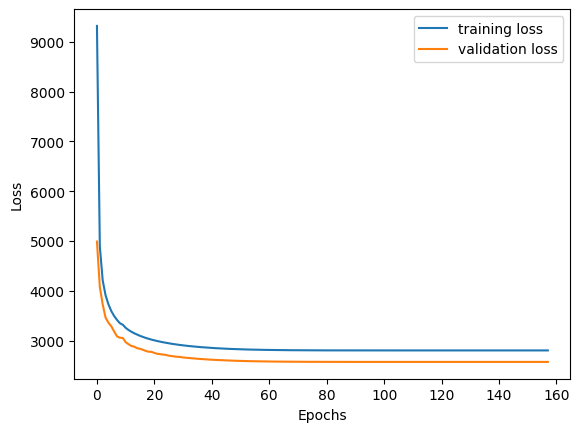

In [43]:
fig, ax = plt.subplots(1,1)

ax.plot(res['loss_train']/4, label='training loss')
ax.plot(res['loss_valid'], label='validation loss')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

ax.legend(loc='upper right')

plt.savefig('models/Loss'+run_name+'.png')
plt.savefig('models/Loss'+run_name+'.pdf')

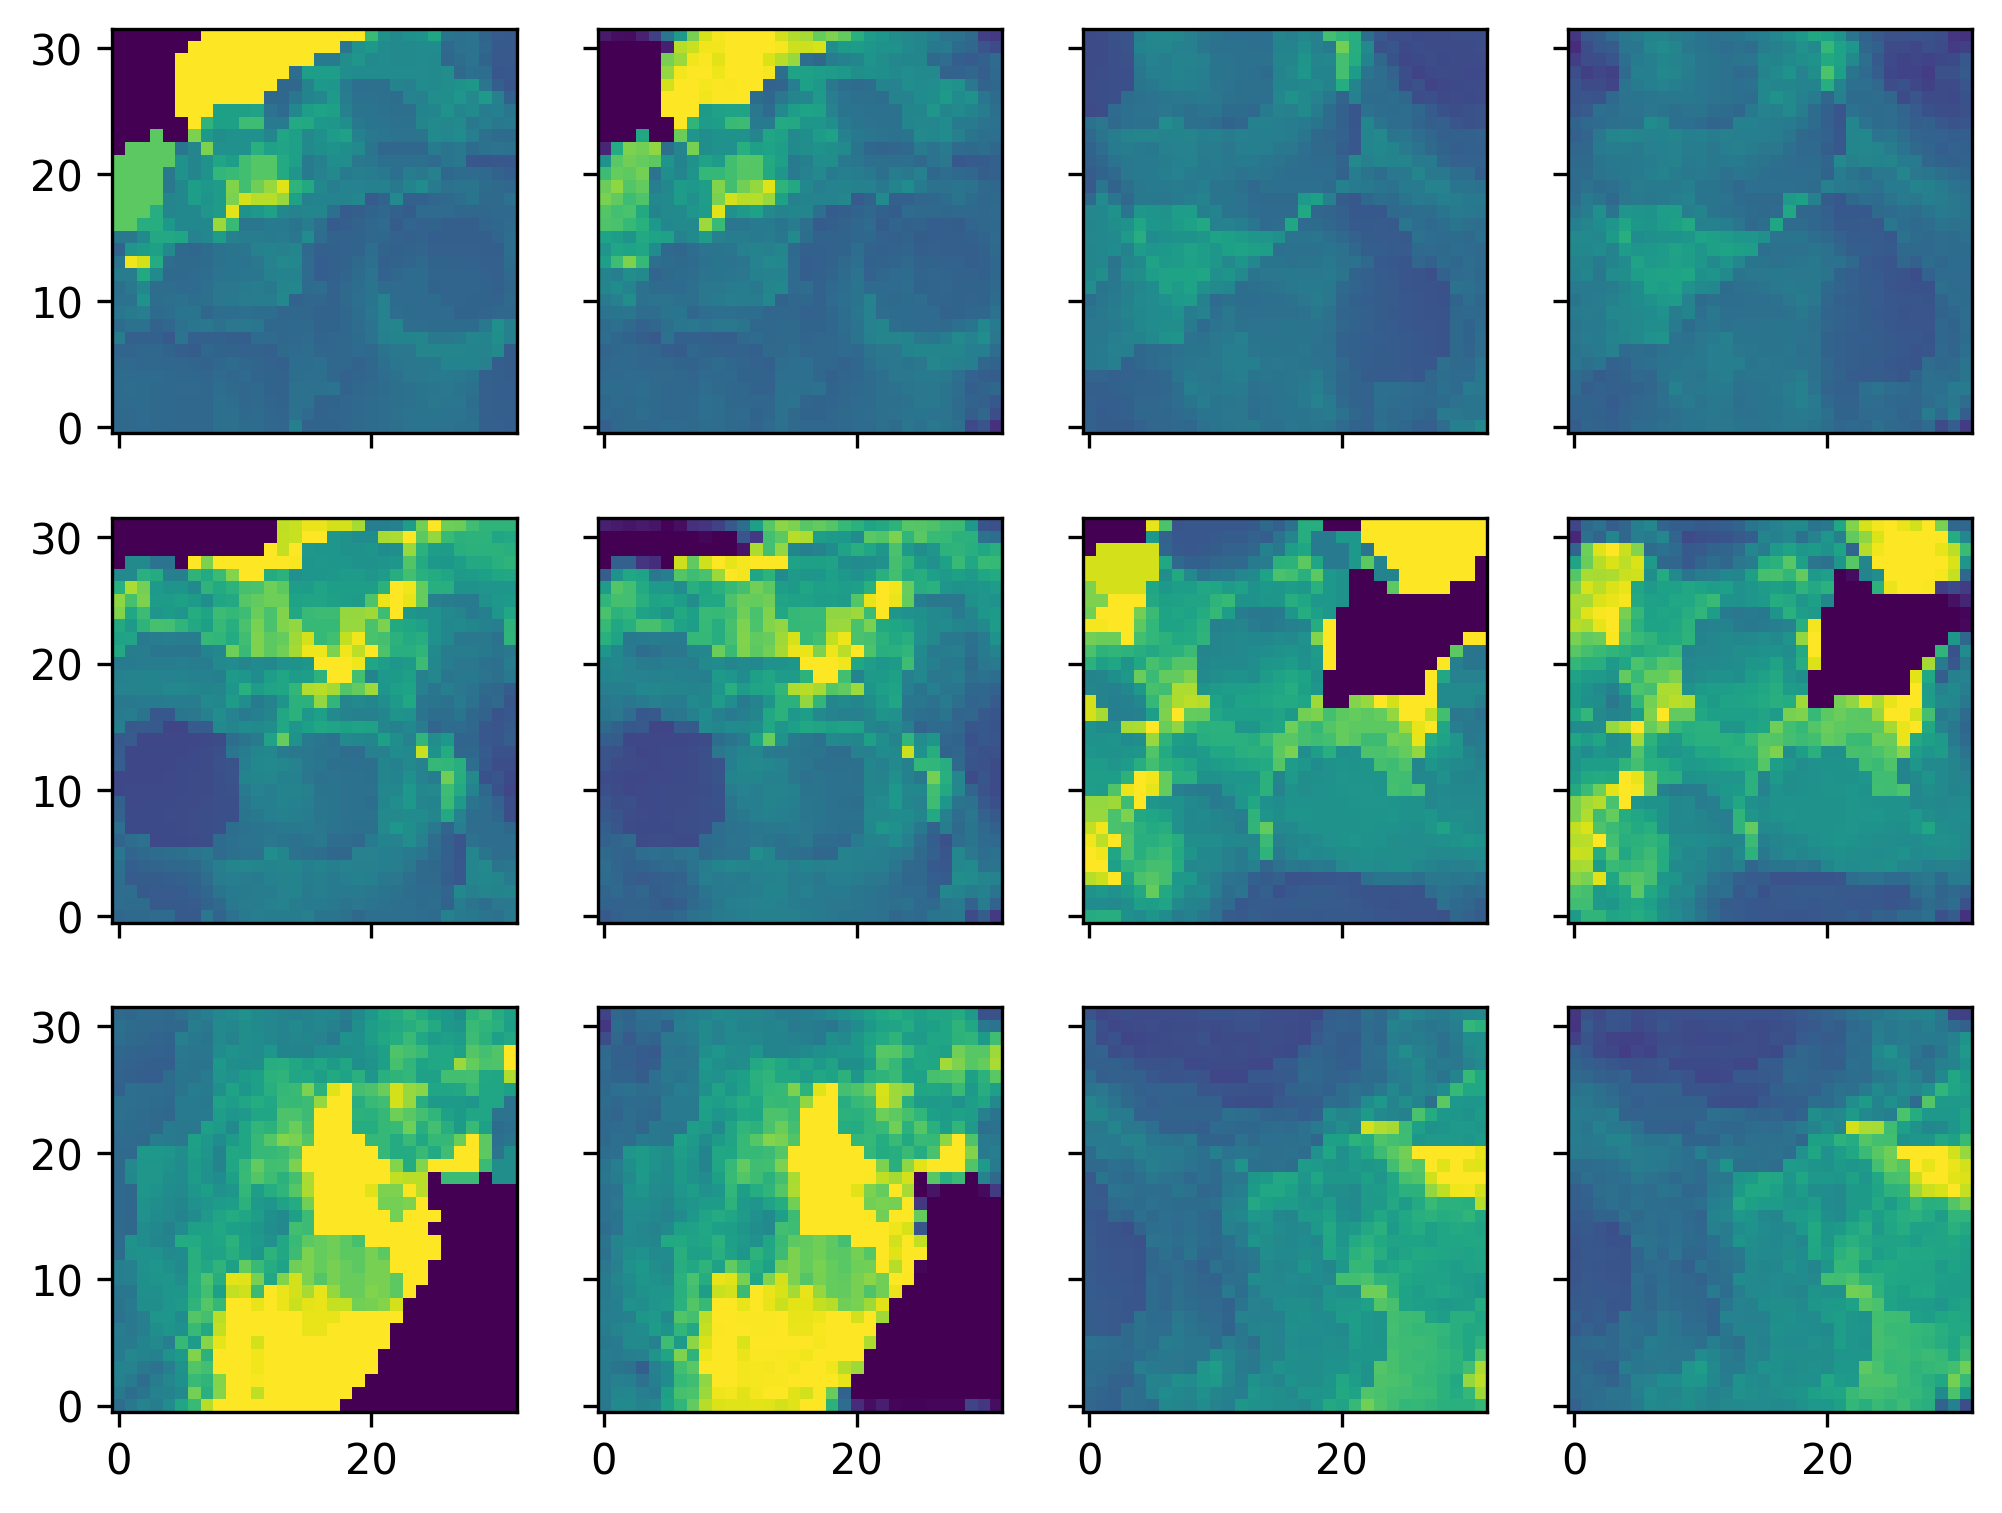

In [44]:
fig, ax = plt.subplots(3, 4, figsize=(8,6), dpi=300, sharex=True, sharey=True)
ax = ax.flatten()

for i, a in enumerate(ax):
    if i % 2: continue
    data = dataset.__getitem__(1000*i)
    ax[  i].imshow(data,                                origin='lower', vmin=0, vmax=2)
    ax[i+1].imshow(mod_train(data.to(device)).to('cpu').detach().numpy()[0], origin='lower', vmin=0, vmax=2)

plt.savefig('models/View'+run_name+'.png')
plt.savefig('models/View'+run_name+'.pdf')